In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

In [2]:
%time ds = DatasetCM26()

CPU times: user 2.66 s, sys: 644 ms, total: 3.3 s
Wall time: 15.2 s


# Extending dataset with 3D data

In [2]:
%time surface = DatasetCM26(source='cmip6')

CPU times: user 2.63 s, sys: 650 ms, total: 3.28 s
Wall time: 13.9 s


In [4]:
%time ocean = DatasetCM26(source='cmip6-3d')

CPU times: user 26.4 s, sys: 8.85 s, total: 35.2 s
Wall time: 21.7 s


In [4]:
%time ocean.param.wet_u.compute();

CPU times: user 1.23 ms, sys: 100 µs, total: 1.33 ms
Wall time: 1.13 ms


Correlation: 0.9692619025085955
Relative Error: 0.26008185744285583
R2 =  0.9360706806182861
R2 max =  0.9400775954127312
Optinal scaling: 1.069846272468567
Nans [test/control]: [0, 0]


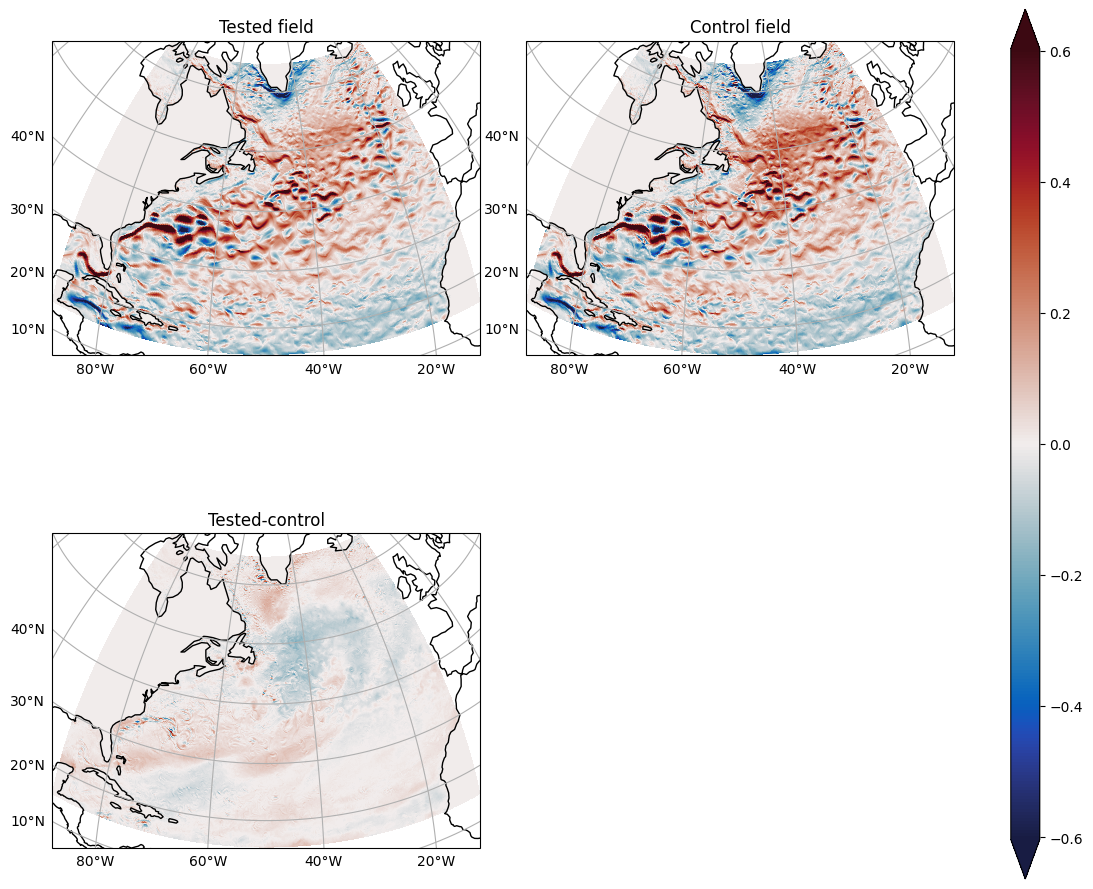

In [5]:
compare(ocean.data.u.isel(zl=0), surface.data.u[-4])

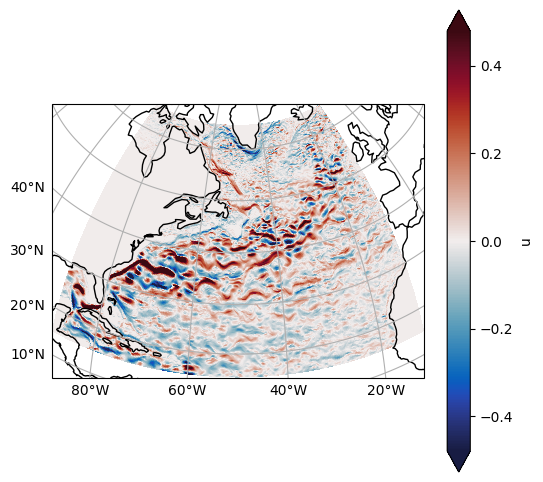

In [6]:
plot(ocean.split().data.u)

In [7]:
%time ocean_coarsen = ocean.coarsen()

CPU times: user 16.1 s, sys: 1.32 s, total: 17.5 s
Wall time: 17.5 s


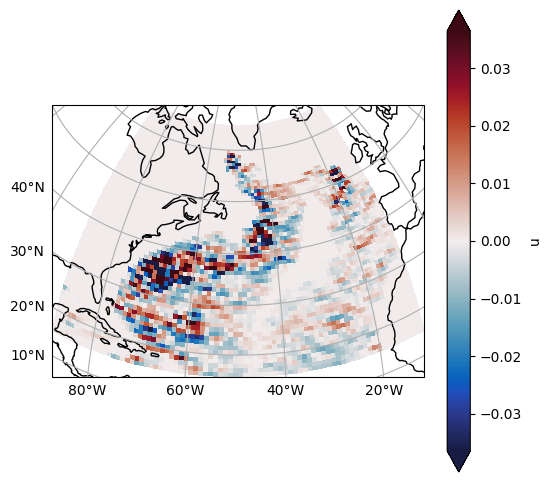

In [8]:
plot(ocean_coarsen.data.u.isel(zl=40))

In [26]:
%time ocean_coarsen.data.u.isel(time=slice(0,1),zl=slice(0,1)).compute();
%time ocean_coarsen.data.u.isel(time=slice(0,14),zl=slice(0,1)).compute();
%time ocean_coarsen.data.u.isel(time=slice(0,1),zl=slice(0,14)).compute();

CPU times: user 1.3 s, sys: 300 ms, total: 1.6 s
Wall time: 1.82 s
CPU times: user 5.01 s, sys: 2.18 s, total: 7.19 s
Wall time: 2.62 s
CPU times: user 6.98 s, sys: 3.66 s, total: 10.6 s
Wall time: 2.75 s


In [28]:
%time SGS = ocean.compute_subgrid_forcing(operator=Filtering(FGR=4)+CoarsenKochkov(), factor=4, percentile=0.0)

CPU times: user 1min 13s, sys: 7.04 s, total: 1min 20s
Wall time: 1min 17s


In [29]:
%time SFS = ocean.compute_subfilter_forcing(operator_filter=Filtering(FGR=4), operator_coarsen=CoarsenKochkov(), factor=4, percentile=0.0)

CPU times: user 1min 4s, sys: 6.03 s, total: 1min 10s
Wall time: 1min 7s


# Can subgrid forcing be described with vertical profile?

In [20]:
print(ocean.data.zl[9])
print(ocean.data.zl[27])

<xarray.DataArray 'zl' ()>
array(98.62325287)
Coordinates:
    zl       float64 98.62
<xarray.DataArray 'zl' ()>
array(996.715271)
Coordinates:
    zl       float64 996.7


Correlation: 0.8176242399684439
Relative Error: 0.4105985411667104
R2 =  0.6431356277351152
R2 max =  0.6684072609359466
Optinal scaling: 0.8372091341219667
Nans [test/control]: [0, 0]


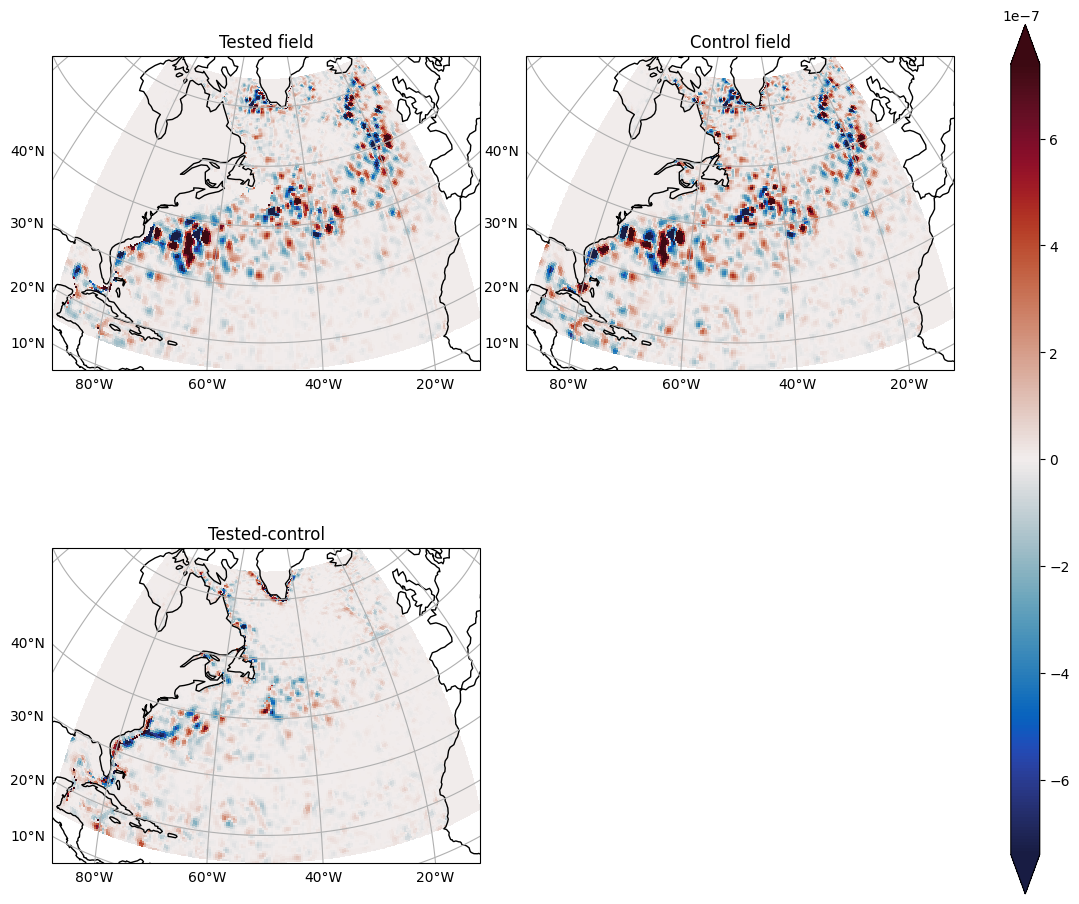

In [21]:
compare(SGS.data.SGSx.isel(zl=9), SGS.data.SGSx.isel(zl=0))

Correlation: 0.34659399192249085
Relative Error: 0.9442953608396772
R2 =  0.09068098800124291
R2 max =  0.12022067730872577
Optinal scaling: 1.9829217841694393
Nans [test/control]: [0, 0]


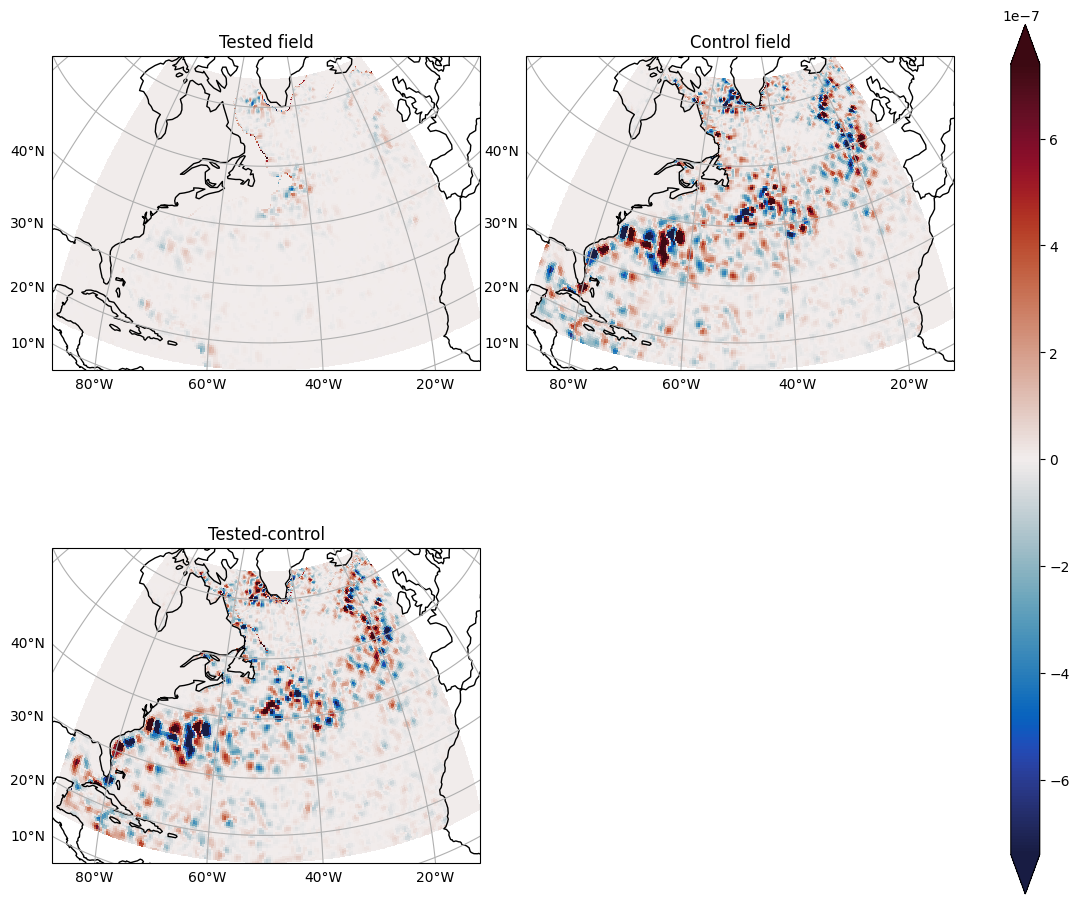

In [22]:
compare(SGS.data.SGSx.isel(zl=27), SGS.data.SGSx.isel(zl=0))

# Difference between subfilter and subgrid forcing

Correlation: 1.0000000000000002
Relative Error: 0.0
R2 =  1.0
R2 max =  1.0
Optinal scaling: 1.0
Nans [test/control]: [0, 0]
Correlation: 1.0000000000000002
Relative Error: 0.0
R2 =  1.0
R2 max =  1.0
Optinal scaling: 1.0
Nans [test/control]: [0, 0]


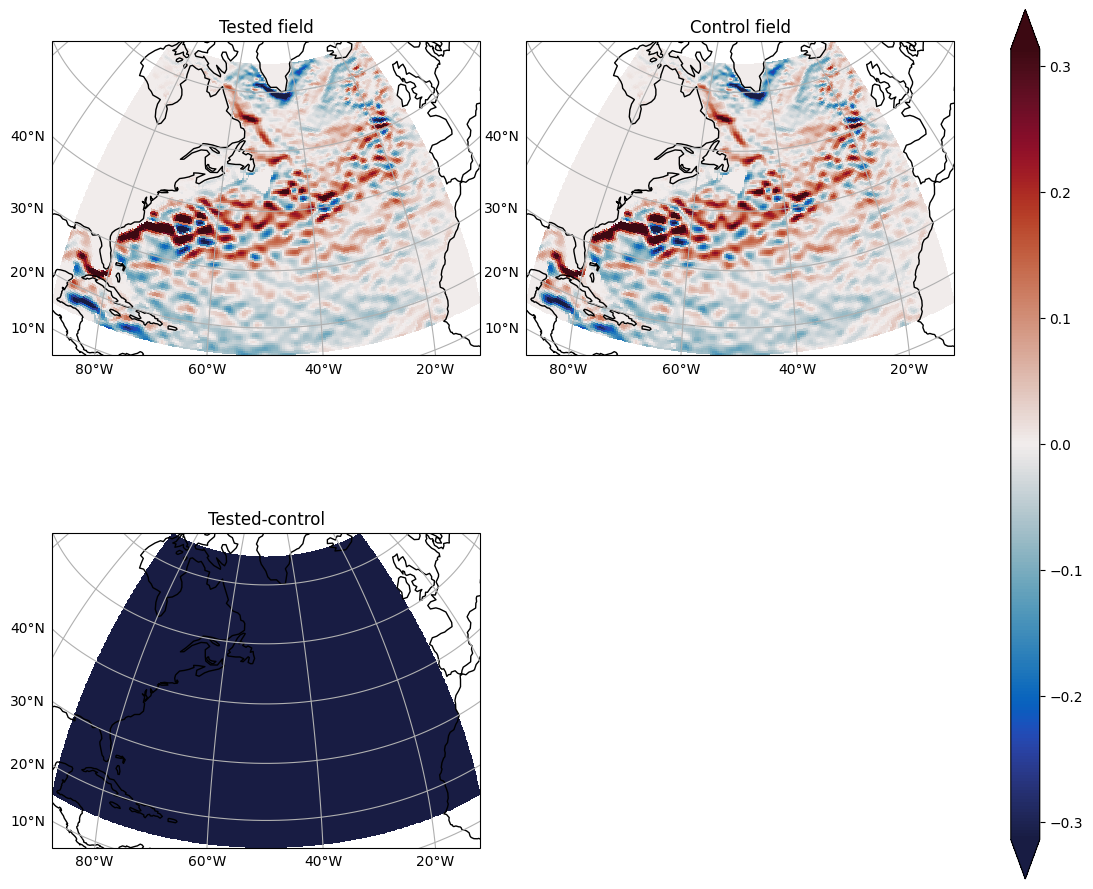

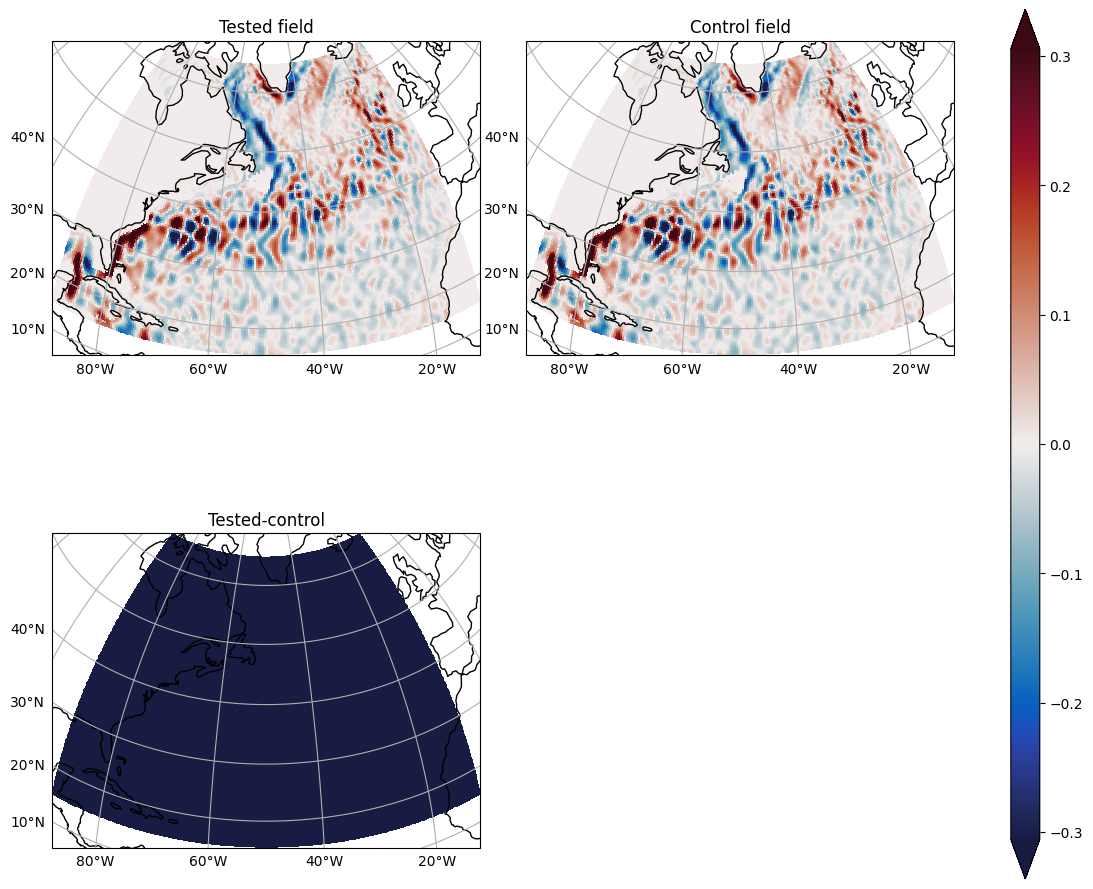

In [30]:
compare(SFS.data.u.isel(zl=9), SGS.data.u.isel(zl=9))
compare(SFS.data.v.isel(zl=9), SGS.data.v.isel(zl=9))

Correlation: 0.9417529859906482
Relative Error: 0.20463981949678367
R2 =  0.8850139390477713
R2 max =  0.8868832836520019
Optinal scaling: 0.9561048081034682
Nans [test/control]: [0, 0]
Correlation: 0.9235512976208101
Relative Error: 0.226267128530904
R2 =  0.8507513908261699
R2 max =  0.8529341347053344
Optinal scaling: 0.9518483257613568
Nans [test/control]: [0, 0]


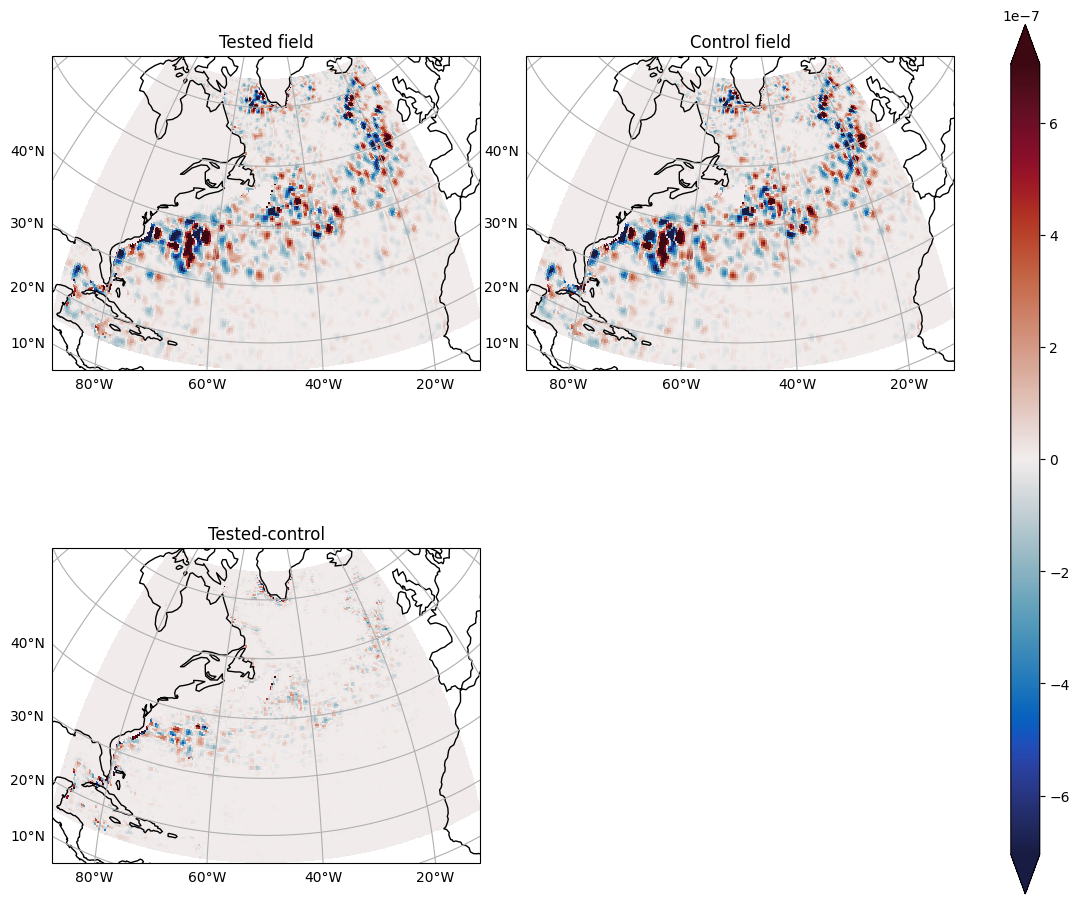

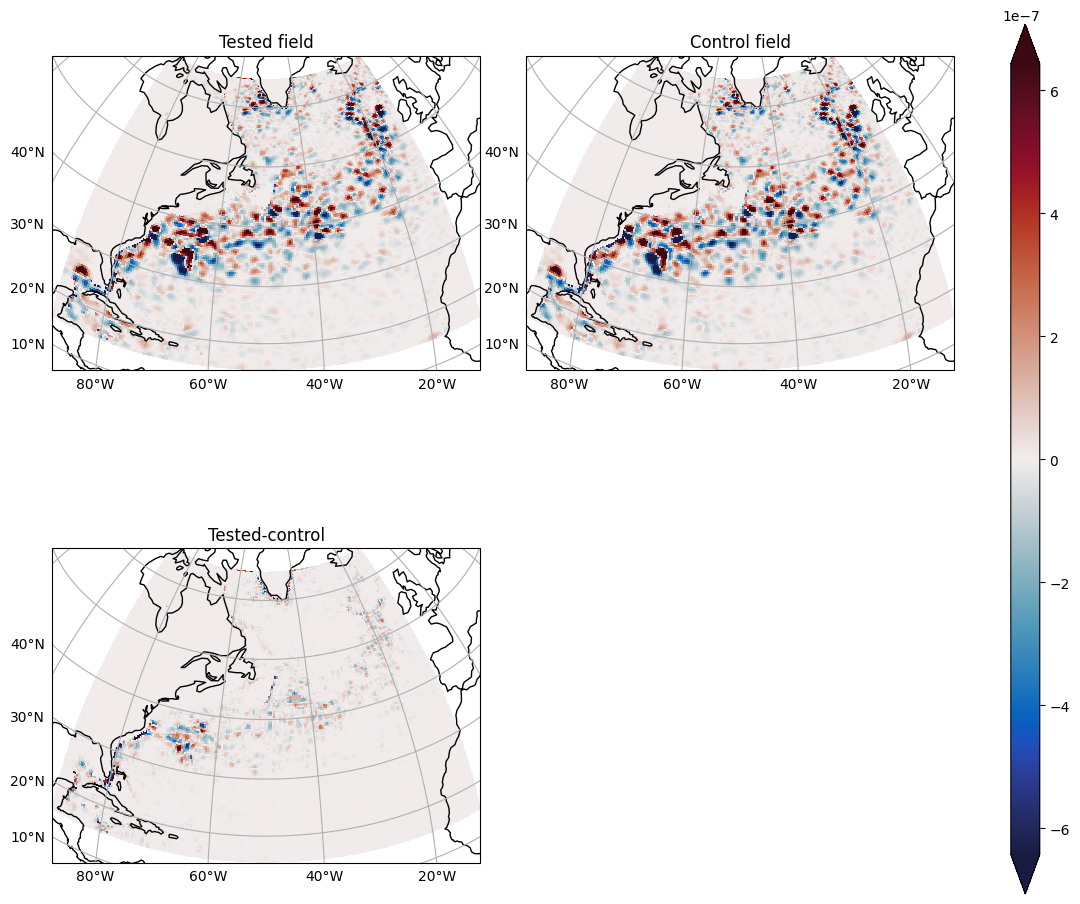

In [31]:
compare(SFS.data.SGSx.isel(zl=9), SGS.data.SGSx.isel(zl=9))
compare(SFS.data.SGSy.isel(zl=9), SGS.data.SGSy.isel(zl=9))

# Xarray parallelism

In [43]:
%time SGS.data.SGSx.isel(zl=1,time=-1).compute();
%time SGS.data.SGSx.isel(zl=slice(0,14),time=-1).compute();
%time SGS.data.SGSx.isel(zl=0,time=slice(0,14)).compute();

CPU times: user 10.3 s, sys: 3.32 s, total: 13.6 s
Wall time: 9.01 s
CPU times: user 39.7 s, sys: 18.4 s, total: 58.2 s
Wall time: 13.1 s
CPU times: user 36.3 s, sys: 15.5 s, total: 51.7 s
Wall time: 12.2 s


In [44]:
%time SGS.data.SGSx.isel(zl=slice(0,50,5),time=0).compute();

CPU times: user 30.8 s, sys: 13.6 s, total: 44.4 s
Wall time: 11.4 s


In [46]:
%time SGS_surface = surface.compute_subgrid_forcing()

CPU times: user 13.9 s, sys: 678 ms, total: 14.6 s
Wall time: 13.8 s


In [49]:
%time SGS_surface.data.SGSx.isel(time=slice(0,1)).compute();
%time SGS_surface.data.SGSx.isel(time=slice(0,14)).compute();

CPU times: user 2.95 s, sys: 1.32 s, total: 4.27 s
Wall time: 2.58 s
CPU times: user 28.8 s, sys: 13.4 s, total: 42.2 s
Wall time: 7.02 s
